In [3]:
import os
import shutil
os.chdir('/content')
if os.path.isdir('./hetvae'):
  shutil.rmtree('./hetvae/')

! git clone https://github.com/mwl10/hetvae
os.chdir('/content/hetvae')
! pip install -r requirements.txt
os.chdir('/content/hetvae/src')
import numpy as np
import torch
import torch.optim as optim
import models
import utils
import my_utils
import importlib
importlib.reload(my_utils)
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline


Cloning into 'hetvae'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 176 (delta 100), reused 86 (delta 34), pack-reused 0
Receiving objects: 100% (176/176), 18.38 MiB | 9.18 MiB/s, done.
Resolving deltas: 100% (100/100), done.
Cloning into 'hetvae'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 176 (delta 100), reused 86 (delta 34), pack-reused 0
Receiving objects: 100% (176/176), 18.38 MiB | 12.16 MiB/s, done.
Resolving deltas: 100% (100/100), done.


In [ ]:
data_objs = utils.get_physionet_data(10)

(6400, 203, 83) (1600, 168, 83)


In [ ]:
dim = data_objs['input_dim']

In [ ]:
print(dim),# so 41 dims to account for, and 41 masks  and 1 tp vector? 

41


In [ ]:
train_loader = data_objs['train_dataloader']

In [ ]:
pbatch = next(iter(train_loader))

In [ ]:
pbatch.shape

torch.Size([10, 203, 83])

In [ ]:
pbatch[0,:,-1] # time values ?

# masks are dim: 2* dim
# time is -1
# values are :dim

tensor([0.0000, 0.0010, 0.0063, 0.0270, 0.0373, 0.0480, 0.0687, 0.0897, 0.1047,
        0.1103, 0.1313, 0.1520, 0.1730, 0.1937, 0.2147, 0.2353, 0.2563, 0.2770,
        0.2980, 0.3187, 0.3203, 0.3397, 0.3603, 0.3813, 0.3917, 0.4020, 0.4230,
        0.4437, 0.4647, 0.4853, 0.5063, 0.5270, 0.5480, 0.5687, 0.5897, 0.6103,
        0.6313, 0.6520, 0.6730, 0.6937, 0.7147, 0.7353, 0.7563, 0.7770, 0.7980,
        0.8187, 0.8397, 0.8403, 0.8813, 0.9020, 0.9073, 0.9230, 0.9333, 0.9437,
        0.9647, 0.9853, 0.9957, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [ ]:
union_tp = utils.union_time(train_loader)

In [ ]:
union_tp.shape

torch.Size([2881])

In [146]:
lcs[0][::2].shape

(134, 3)

In [190]:
lc_files = glob('/content/hetvae/data/EDELSON/NGC5548*')

(74, 3)

In [204]:
lcs,max_len = my_utils.file_to_np(*(lc_files*30))

lcs = lcs[:128]
# set starting time value to zero 
#lcs = [lc[:,0] - lc[0,0] for lc in lcs]
# normalizing function now! 
for lc in lcs:
  lc[:,0] = lc[:,0] - lc[0,0]
print('-'*50)
lcs = my_utils.handle_dups(lcs)

for i, lc in enumerate(lcs):
  lc = lc[::4]
  lcs[i] = lc
max_len = max([lc.shape[0] for lc in lcs])

union_tp = my_utils.union_timepoints(lcs)


print(len(union_tp))
# we want the light curves like
# len_longest_lc, 0 will be time, 1 will be dims 
lcs = my_utils.include_union_tp(lcs, max_len)
lcs.shape # fire!

dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W2.dat:	(259, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_HX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W2.dat:	(259, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_HX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W2.dat:	(259, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_HX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of 

(128, 67, 3)

In [205]:
# round? 
std_time = np.std(union_tp)
#std_flux = np.std(lcs[:,:,1].flatten())
#mean_flux = np.mean(lcs[:,:,1].flatten())
union_tp = union_tp / std_time
lcs[:,:,0] = lcs[:,:,0] / std_time

# normalize flux for light curves individually
for lc in lcs:
  lc[:,1] = lc[:,1] / np.std(lc[:,1])




In [206]:
lcs = lcs.astype(np.float32)
union_tp = union_tp.astype(np.float32)
union_tp = torch.tensor(union_tp)
train_loader = torch.utils.data.DataLoader(lcs, batch_size=8)
dim = 1



```
# This is formatted as code
```

## Setting up arguments

In [207]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [219]:
args = Namespace(batch_size=8, bound_variance=True, const_var=False, dataset='toy', dropout=0.0, 
                 elbo_weight=1.0, embed_time=128, enc_num_heads=1, intensity=True, k_iwae=1, kl_annealing=False, 
                 kl_zero=False, latent_dim=64, lr=0.000001, mixing='concat', mse_weight=0.0, n=256, net='hetvae', 
                 niters=1000, norm=False, normalize_input='znorm', num_ref_points=64, rec_hidden=64, recon_loss=False, 
                 sample_tp=0.5, save=True, seed=0, shuffle=True, std=0.1, var_per_dim=False, width=512)

In [209]:
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)

In [210]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [211]:
lcs.shape

(128, 67, 3)

## **Generating Synthetic Data**

In [212]:
# why is it subtracting 1 for the recon mask?
# dataset class that loads agn by folder you give it? agn object, agn.addLC('').addLC('')
# what is happening with the normalizations...
# kl negative? negative losses in general???
# make this capable of running on GPU
# fixing visualization
# adding error bars in the loss function?
# is my union_tp right? 
# different sequence sizes, some drastically shorter... how to make this not matter? does it? 


# do we subsample the light curve like they do...?
# i guess we do because you're just randomly selecting points each go round...


# make the masks beforehand...
def make_masks(lcs, batch_size=8, frac=0.4):
  # will depend on dimensions later
  subsampled_mask = np.zeros_like(lcs[:,:,1])
  recon_mask = np.zeros_like(lcs[:,:,1])
  for i,lc in enumerate(lcs):
    indexes = lc[:,1].nonzero()[0]
    # this should vary relativ
    length = int(np.round(len(indexes) * frac))
    obs_points = np.sort(np.random.choice(indexes, size=length, replace=False))
    subsampled_mask[i, obs_points] = 1
    #recon_mask[i] = np.logical_not(subsampled_mask[i])

    recon_mask[i] = np.logical_xor(lc[:,1], subsampled_mask[i])

  recon_mask = np.split(recon_mask, len(subsampled_mask) / batch_size)
  subsampled_mask = np.split(subsampled_mask, len(subsampled_mask) / batch_size)
  return subsampled_mask, recon_mask

smask, rmask = make_masks(lcs, batch_size=8)
print(smask[-1].shape)




(8, 67)


## **Loading HeTVAE model**

In [186]:
print(smask[0][0].sum(), rmask[0][0].sum())
# right now we are turning every point thats not a 1 in the smask subset to rmask

26.0 39.0


In [221]:
net = models.load_network(args, dim, union_tp) # dim = 1
params = list(net.parameters())
optimizer = optim.Adam(params, lr=.0001)
# definitly want a decaying error rate...

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[600*8,700*8], gamma=0.1)


In [203]:
train_batch.shape
subsampled_mask.shape


torch.Size([9, 67, 1])

## **Training**

In [222]:
for epoch in range(1, 1000+1):#args.niters + 1):
      train_loss = 0
      train_n = 0
      avg_loglik, avg_kl, mse, mae = 0, 0, 0, 0
      for i, train_batch in enumerate(train_loader):
          batch_len = train_batch.shape[0] 
          train_batch = train_batch.to(device)
          subsampled_mask = torch.tensor(smask[i][:, :, np.newaxis]).to(device) # should look like our flux values?
          recon_mask = torch.tensor(rmask[i][:, :,np.newaxis]).to(device)
          seqlen = train_batch.size(1) 
          # subsampled flux values and their corresponding masks....
          context_y = torch.cat((
              train_batch[:, :, 1:2] * subsampled_mask, subsampled_mask
          ), -1) 
    # #   def compute_unsupervised_loss(
    # #     self, context_x, context_y, target_x, target_y, num_samples=1, beta=1.
    # # ):

          loss_info = net.compute_unsupervised_loss(
              train_batch[:, :, 0], # context_x, times
              context_y,             # context_y
              train_batch[:, :, 0], # target_x, same times? 
              torch.cat((            # flux values with only recon_mask values showing
                  train_batch[:, :, 1:2] * recon_mask, recon_mask
              ), -1),
              num_samples=args.k_iwae, # 1? 
              beta=1,       # ? 
          )
          optimizer.zero_grad()
          loss_info.composite_loss.backward()
          optimizer.step()
          #scheduler.step()
          train_loss += loss_info.composite_loss.item() * batch_len
          avg_loglik += loss_info.loglik * batch_len
          avg_kl += loss_info.kl * batch_len
          mse += loss_info.mse * batch_len
          mae += loss_info.mae * batch_len
          train_n += batch_len

      if epoch % 100 == 0:
          print(
              'Iter: {}, train loss: {:.4f}, avg nll: {:.4f}, avg kl: {:.4f}, '
              'mse: {:.6f}, mae: {:.6f}'.format(
                  epoch,
                  train_loss / train_n,
                  -avg_loglik / train_n,
                  avg_kl / train_n,
                  mse / train_n,
                  mae / train_n
              )
          )
    #       for loader, num_samples in [(val_loader, 5), (test_loader, 100)]:
    #           utils.evaluate_hetvae(
    #               net,
    #               dim,
    #               loader,
    #               0.5,
    #               shuffle=False,
    #               k_iwae=num_samples,
    #               model_name=args.net,
    #           )

Iter: 100, train loss: 37.3381, avg nll: 37.3002, avg kl: 0.0380, mse: 0.476040, mae: 0.519691
Iter: 200, train loss: 35.7717, avg nll: 35.7464, avg kl: 0.0254, mse: 0.450930, mae: 0.503084
Iter: 300, train loss: 33.3178, avg nll: 33.2950, avg kl: 0.0228, mse: 0.387989, mae: 0.467161
Iter: 400, train loss: 30.6198, avg nll: 30.5862, avg kl: 0.0336, mse: 0.332854, mae: 0.424765
Iter: 500, train loss: 29.8270, avg nll: 29.7819, avg kl: 0.0451, mse: 0.319680, mae: 0.413446
Iter: 600, train loss: 29.2008, avg nll: 29.1414, avg kl: 0.0593, mse: 0.315011, mae: 0.408983
Iter: 700, train loss: 28.5720, avg nll: 28.5097, avg kl: 0.0623, mse: 0.313444, mae: 0.406459
Iter: 800, train loss: 28.1885, avg nll: 28.1061, avg kl: 0.0824, mse: 0.311461, mae: 0.402875
Iter: 900, train loss: 27.8769, avg nll: 27.7929, avg kl: 0.0839, mse: 0.307654, mae: 0.399242
Iter: 1000, train loss: 27.6183, avg nll: 27.5121, avg kl: 0.1062, mse: 0.307438, mae: 0.398138


## **Vizualization with increasing number of observations**

In [225]:


def viz(test_loader, k_iwae=1, n_max=10):
    pred_mean, pred_std = [], []
    masks = []
    targets = []
    tp =[]
    np.random.seed(0)
    # don't keep track of gradients....
    with torch.no_grad():
        # how many points we show in the light curve? 
        for low in [10,30,50]:
            for i, batch in enumerate(test_loader):
                
                batch_len = batch.shape[0]
                batch = batch.to(device)
                #subsampled_mask = torch.zeros_like(batch[:, :, dim:2 * dim]).to(device)
                subsampled_mask = torch.tensor(smask[i][:, :, np.newaxis]).to(device)
                seqlen = batch.size(1)
                # for i in range(batch_len):
                  
                #     length = low
                #     obs_points = np.sort(np.random.choice(np.arange(seqlen), size=length, replace=False))
                #     subsampled_mask[i, obs_points, :] = 1
                #recon_mask = batch[:, :, dim:2 * dim] - subsampled_mask
                context_y = torch.cat((batch[:, :, 1:2] * subsampled_mask, subsampled_mask), -1)
                px, _ = net.get_reconstruction(batch[:, :, 0], context_y, batch[:, :, 0], num_samples=k_iwae)
                pred_mean.append(px.mean.cpu().numpy())
                pred_std.append(torch.exp(0.5 * px.logvar).cpu().numpy())
                targets.append((batch[:, :, 1:2]).cpu().numpy())
                masks.append(subsampled_mask.cpu().numpy())
                tp.append(batch[:, :, 0].cpu().numpy())
                if len(tp) % (n_max // 5) == 0:
                    break
    pred_mean = np.concatenate(pred_mean, axis=1)
    pred_std = np.concatenate(pred_std, axis=1)
    targets = np.concatenate(targets, axis=0)
    masks = np.concatenate(masks, axis=0)
    tp = np.concatenate(tp, axis=0)
    inputs = np.ma.masked_where(masks < 1., targets)
    print(pred_mean.shape, pred_std.shape, targets.shape, masks.shape, tp.shape)
    preds = np.random.randn(k_iwae // 2, k_iwae, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3]) * pred_std + pred_mean
    preds = preds.reshape(-1, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3])
    median = preds.mean(0) #np.quantile(preds, 0.5, axis=0)
    quantile2 = np.quantile(preds, 0.850, axis=0)
    quantile1 = np.quantile(preds, 0.150, axis=0)
    print(preds.shape)
    print(preds)
    
    w = 2.0
    for index in range(n_max):
        plt.figure(figsize=(12.5, 1.5))
        for j in range(3):
            plt.subplot(1, 3, j + 1)
            plt.fill_between(tp[n_max * j + index], quantile1[n_max * j + index, :, 0], quantile2[n_max * j + index, :, 0], alpha=0.6, facecolor='#65c9f7', interpolate=True)
            plt.plot(tp[n_max * j + index], median[n_max * j + index, :, 0], c='b', lw=w, label='Reconstructions')
            #plt.plot(tp[n_max * j + index], gt[index], c='r', lw=w, label='Ground Truth')
            plt.scatter(tp[n_max * j + index], inputs[n_max * j + index, :, 0], c='k', lw=w, label='Observed Data')
            plt.xlim([0, 1])
            plt.xticks([])
            plt.yticks([])
            if j == 1 and index == 0:
                plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.6,1.5))
            
        plt.show()


In [110]:

torch.cuda.empty_cache()
pred_mean, pred_std = [],[]
masks = []
targets = []
tp = []
k_iwae = 10
np.random.seed(0)
with torch.no_grad():
  batch = next(iter(train_loader)).to(device)
  print(batch.shape)
  batch_len = len(batch)
  subsampled_mask = torch.tensor(smask[i][:, :, np.newaxis]).to(device)
  seqlen = batch.size(1)
  context_y = torch.cat((batch[:,:,1:2] * subsampled_mask, subsampled_mask), -1)
  context_y = torch.cat((batch[:, :, :dim] * subsampled_mask, subsampled_mask), -1)
  px, _ = net.get_reconstruction(batch[:, :, 0], context_y, batch[:, :, 0], num_samples=k_iwae)
  pred = px.mean.cpu().numpy()
  pred_std = torch.exp(0.5 * px.logvar).cpu().numpy() # e^(0.5 * logvar)

points = batch.cpu().numpy()


torch.Size([8, 267, 3])


In [125]:
avg_stds = np.mean(pred_std, axis=0)
avg_means = np.mean(pred, axis=0)
# sample from those, 



In [135]:
test = smask[0][0,:] * points[0,:,1]

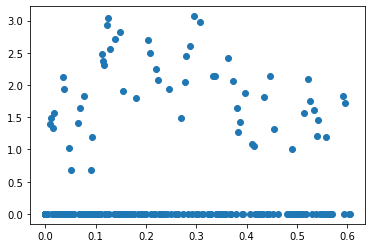

In [136]:
plt.scatter(points[0,:,0], test)

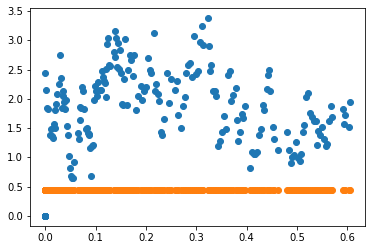

In [128]:
plt.scatter(points[0,:,0], points[0,:,1])
plt.scatter(points[0,:,0], avg_means[0,:,0])

(267,)

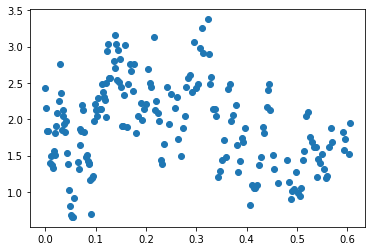

In [90]:
zeros = points[0,:,1] == 0
points[0,zeros,1] = float('nan')
plt.scatter(points[0,:,0], points[0,:,1])

points[0,:,1].shape

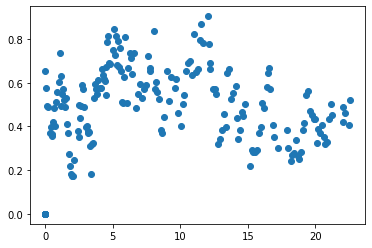

In [75]:
plt.scatter(lcs[1][:,0], lcs[1][:,1])

In [ ]:
points.shape

(2, 267, 3)

In [ ]:

std_flux = np.std(points[:, :, 1].flatten())
print(std_flux)
#points[:,:,1] = points[:,:,1] / std_flux
print(std_flux)

0.7733767
0.7733767


In [91]:
zeros = points[0,:,1] == 0
points[0,zeros,1] = float('nan')

In [ ]:
pred.shape

(10, 2, 267, 1)

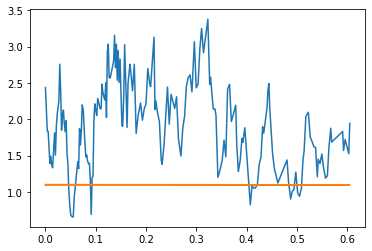

In [103]:
pred.shape # k, batch, num points.... so k samples, for each batch, for each time point 

fig, ax = plt.subplots()
# normalizing problem? 
ax.plot(points[0,:,0], points[0,:,1])
ax.plot(points[0,:,0], pred[0,6,:,0])

In [ ]:
batch = next(iter(train_loader))[:,:,1]

In [65]:
batch[0,:,1]

tensor([0.6520, 0.5760, 0.4920, 0.4910, 0.3720, 0.3990, 0.3650, 0.3560, 0.4190,
        0.4850, 0.4030, 0.5120, 0.5580, 0.6040, 0.7380, 0.6310, 0.4950, 0.5490,
        0.5690, 0.5190, 0.4890, 0.5300, 0.4090, 0.3710, 0.2750, 0.2170, 0.1810,
        0.1750, 0.1750, 0.2460, 0.3790, 0.3530, 0.5000, 0.4400, 0.4930, 0.5880,
        0.5690, 0.4900, 0.3960, 0.4040, 0.3800, 0.3710, 0.3730, 0.3110, 0.1840,
        0.3190, 0.3250, 0.5290, 0.5920, 0.5700, 0.5490, 0.6120, 0.5740, 0.5740,
        0.6650, 0.6340, 0.6190, 0.6060, 0.6700, 0.5420, 0.7860, 0.8120, 0.6890,
        0.6870, 0.7500, 0.8450, 0.7250, 0.8120, 0.6790, 0.7890, 0.6710, 0.7570,
        0.6540, 0.5120, 0.5090, 0.6240, 0.8100, 0.5050, 0.6670, 0.7380, 0.7130,
        0.6400, 0.7380, 0.4830, 0.5480, 0.5950, 0.5320, 0.5730, 0.5910, 0.7220,
        0.6680, 0.6550, 0.8380, 0.5710, 0.6030, 0.5570, 0.5270, 0.3850, 0.3690,
        0.4430, 0.6540, 0.5170, 0.6270, 0.5750, 0.6180, 0.4630, 0.4000, 0.5020,
        0.5460, 0.6550, 0.6880, 0.6990, 

(15, 48, 67, 1) (15, 48, 67, 1) (48, 67, 1) (48, 67, 1) (48, 67)
(105, 48, 67, 1)
[[[[4.80731413]
   [4.08696571]
   [4.36700656]
   ...
   [5.40127857]
   [3.68468903]
   [3.04795849]]

  [[3.39167723]
   [2.64252679]
   [3.14830622]
   ...
   [5.20732832]
   [2.77634948]
   [3.15847606]]

  [[2.40449505]
   [3.14653984]
   [3.07929833]
   ...
   [3.95527551]
   [3.55378674]
   [2.72562882]]

  ...

  [[1.20324391]
   [0.94375982]
   [1.12154504]
   ...
   [1.14324822]
   [1.34662578]
   [1.37034793]]

  [[4.36618134]
   [1.88044123]
   [2.74792689]
   ...
   [2.59236319]
   [2.39134868]
   [2.74768125]]

  [[3.21044427]
   [3.41673957]
   [3.38499965]
   ...
   [4.78256899]
   [3.24268416]
   [3.65077028]]]


 [[[3.81455553]
   [2.99668829]
   [3.29973354]
   ...
   [5.30823461]
   [3.72458489]
   [3.59632152]]

  [[4.01832373]
   [2.76660378]
   [3.90885599]
   ...
   [4.92904915]
   [2.99313397]
   [3.72213056]]

  [[3.17922109]
   [2.93185958]
   [3.09054867]
   ...
   [3.66794672

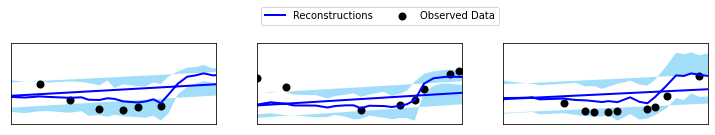

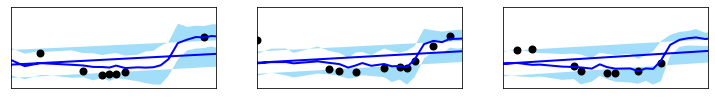

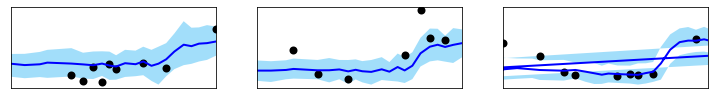

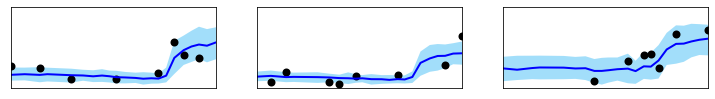

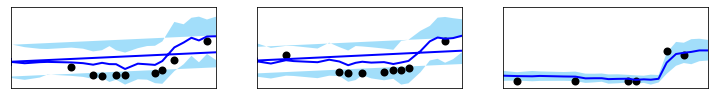

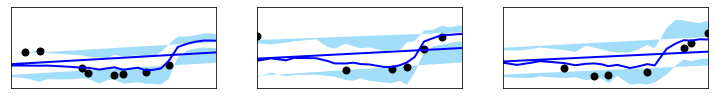

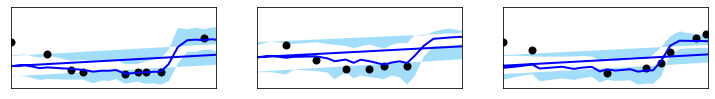

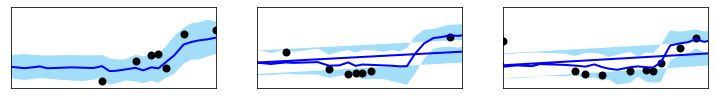

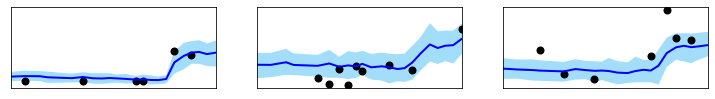

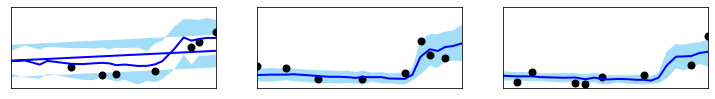

In [226]:
viz(train_loader, k_iwae=15)